In [1]:
import pandas as pd
from itertools import combinations

df1 = pd.read_csv("data/ImdbTitleBasics.csv",encoding='ISO-8859-1',low_memory = False)
df2 = pd.read_csv("data/ImdbName.csv",encoding='ISO-8859-1',low_memory = False)
df3 = pd.read_csv("data/ImdbTitlePrincipals.csv",encoding='ISO-8859-1',low_memory = False)


filtered_df = df1[df1['titleType'] == 'movie']
filtered_df['startYear'] = pd.to_numeric(filtered_df['startYear'], errors='coerce')
filtered_df = filtered_df[filtered_df['startYear'].between(1927, 1960)]
filtered_df = filtered_df.drop(['originalTitle','isAdult','endYear','runtimeMinutes'],axis=1)


C:\Users\33695\AppData\Local\Temp\ipykernel_20012\3374629955.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['startYear'] = pd.to_numeric(filtered_df['startYear'], errors='coerce')


C:\Users\33695\AppData\Local\Temp\ipykernel_19856\2715019274.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['startYear'].replace('\\N', pd.NA, inplace=True)


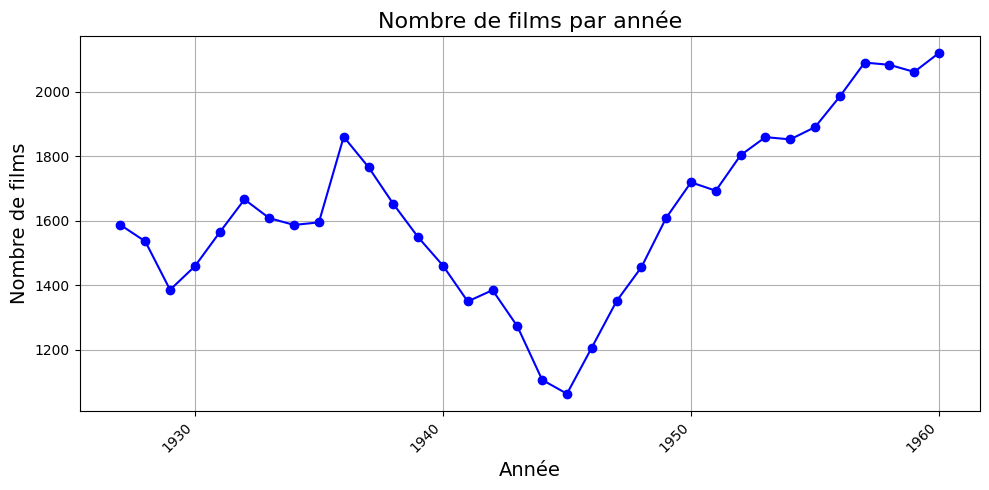

In [36]:
import matplotlib.pyplot as plt

# Supposons que filtered_df est ton DataFrame filtré
# Remplacer les valeurs '\N' par NaN, puis supprimer les lignes avec des valeurs manquantes
filtered_df['startYear'].replace('\\N', pd.NA, inplace=True)
filtered_df.dropna(subset=['startYear'], inplace=True)

# Convertir startYear en entier
filtered_df['startYear'] = filtered_df['startYear'].astype(int)

# Calculer le nombre de films par année
films_per_year = filtered_df['startYear'].value_counts().sort_index()

# Tracer le graphique
plt.figure(figsize=(10, 5))
plt.plot(films_per_year.index, films_per_year.values, marker='o', linestyle='-', color='blue')
plt.xlabel('Année', fontsize=14)
plt.ylabel('Nombre de films', fontsize=14)
plt.title('Nombre de films par année', fontsize=16)
plt.grid(True)

# Filtrer les années à afficher tous les 10 ans
years_to_display = [year for year in films_per_year.index if year % 10 == 0]
plt.xticks(years_to_display, rotation=45, ha='right')

# Ajuster la mise en page
plt.tight_layout()

# Afficher le graphique
plt.show()


In [2]:
   
def create_graph(start_date, end_date):
    if start_date > end_date:
        raise ValueError("La date de début doit être antérieure à la date de fin.")
    
    if start_date < 1927 or end_date > 2000:
        raise ValueError("Les dates doivent être comprises entre 1927 et 2000.")

    df1 = pd.read_csv("data/ImdbTitleBasics.csv",encoding='ISO-8859-1',low_memory = False)
    df2 = pd.read_csv("data/ImdbName.csv",encoding='ISO-8859-1',low_memory = False)
    df3 = pd.read_csv("data/ImdbTitlePrincipals.csv",encoding='ISO-8859-1',low_memory = False)

    filtered_df = df1[df1['titleType'] == 'movie']
    filtered_df.dropna(subset='startYear')
    filtered_df.loc[:, 'startYear'] = pd.to_numeric(filtered_df['startYear'], errors='coerce')
    filtered_df = filtered_df[filtered_df['startYear'].between(start_date, end_date)]
    filtered_df = filtered_df.drop(['originalTitle','isAdult','endYear','runtimeMinutes'],axis=1)

    df3_filtered = df3[df3['tconst'].isin(filtered_df['tconst'])]
    df3_filtered = df3_filtered.drop(['job','characters','ordering'],axis=1)

    categories_to_keep = ['actor', 'director', 'writer']
    filtered_nodes = df3_filtered[df3_filtered['category'].isin(categories_to_keep)]

    df2_filtered = df2[df2['nconst'].isin(filtered_nodes['nconst'])]

    df3_merged = filtered_nodes.merge(df2_filtered[['nconst', 'primaryName']], on='nconst', how='left')

    df3_merged = df3_merged.dropna()
    df3_merged.rename(columns={'nconst': 'Id'}, inplace=True)
    df3_merged.rename(columns={'primaryName' : 'Label'}, inplace = True)




    # Créer les arêtes avec des poids cumulés
    edges = {}
    for tconst, group in df3_merged.groupby('tconst'):
        collaborator_pairs = combinations(group['Id'], 2)  # Paires de collaborateurs
        for pair in collaborator_pairs:
            # Utiliser un tuple comme clé pour le dictionnaire
            edge_key = (min(pair), max(pair))  # Utiliser min et max pour standardiser les paires
            if edge_key in edges:
                edges[edge_key]['Weight'] += 1  # Incrémenter le poids
            else:
                edges[edge_key] = {
                    'Source': edge_key[0],
                    'Target': edge_key[1],
                    'Label': tconst,
                    'Weight': 1  # Initialiser le poids à 1
                }

    # Convertir le dictionnaire en DataFrame
    edges_df = pd.DataFrame(edges.values())

    # Regrouper par Source et Destination pour additionner les poids
    edges_weighted = edges_df.groupby(['Source', 'Target']).agg({'Weight': 'sum'}).reset_index()

    print("Nombre d'arêtes après regroupement : ", edges_weighted.shape[0])


    df3_merged = df3_merged.drop_duplicates(subset='Id')
    df3_merged = df3_merged.drop('tconst',axis=1)

    edges_df.to_csv(f'edges_{start_date}_to_{end_date}.csv', index=False)
    df3_merged.to_csv(f"nodes_{start_date}_to_{end_date}.csv",index=False)

In [ ]:
dates = [(1927, 1960), (1960, 1980), (1980, 2000)]

for start_date, end_date in dates:
    create_graph(start_date, end_date)

Nombre d'arêtes après regroupement :  199818
